In [3]:
import sys
import time
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, Column 
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy.optimize import curve_fit
from scipy import odr
import pylab as py
from matplotlib import gridspec
import sklearn.datasets as ds
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
import corner
import emcee
import scipy.optimize as op
from scipy.linalg import cholesky, inv,det
from scipy.optimize import minimize
import random
from astropy.table import Table, Column
from linear_mcmc import *

from redTools import *
from Kcorrect import *
from calibTools import *

In [202]:
####################################### Set Axes
def set_axes(ax, xlim=None, ylim=None, fontsize=16, twinx=True, twiny=True, minor=True, inout='in'):
        
        if not ylim is None:
            ax.set_ylim(ylim)
        else:
            ylim = ax.get_ylim() 
            
        if not xlim is None:    
            ax.set_xlim(xlim) 
        else:
            xlim = ax.get_xlim()
            
        ax.tick_params(which='major', length=6, width=1., direction=inout)
#         if minor:
        ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout)  
        
        if twiny:
            y_ax = ax.twinx()
            y_ax.set_ylim(ylim)
            y_ax.set_yticklabels([])
            y_ax.minorticks_on()
            y_ax.tick_params(which='major', length=6, width=1., direction=inout)
            if minor:
                y_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout) 
        
        if twinx:
            x_ax = ax.twiny()
            x_ax.set_xlim(xlim)
            x_ax.set_xticklabels([])
            x_ax.minorticks_on()
            x_ax.tick_params(which='major', length=6, width=1.0, direction=inout)
            if minor:
                x_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout)     

        for tick in ax.xaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
        for tick in ax.yaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
        
        return x_ax, y_ax

In [69]:
table   = np.genfromtxt('corrected_mags_linewidth_all.csv' , delimiter='|', 
                        filling_values=-1, names=True, dtype=None, encoding=None)

catal   = np.genfromtxt('ESN_HI_catal_all.csv' , delimiter=',', 
                        filling_values=-1, names=True, dtype=None, encoding=None)
pgc_catal   = catal['pgc']
R50u_catal  = catal['R50_u']
R50g_catal  = catal['R50_g']
R50r_catal  = catal['R50_r']
R50i_catal  = catal['R50_i']
R50z_catal  = catal['R50_z']
R50w1_catal = catal['R50_w1']
R50w2_catal = catal['R50_w2']
Sba_catal   = catal['Sba']
Wba_catal   = catal['Wba']

pgc_tab = table['pgc']
u_tab   = table['u_sss']
g_tab   = table['g_sss']
r_tab   = table['r_sss']
i_tab   = table['i_sss']
z_tab   = table['z_sss']
w1_tab  = table['w1_sss']
w2_tab  = table['w2_sss']
m21_tab = table['m21']
inc_tab = table['inc']
Sqlt = table['Sqlt']
Wqlt = table['Wqlt']
logWimx   = table['logWimx']

N = len(pgc_tab)
inc  = np.zeros(N)
m21  = np.zeros(N)
Sba  = np.zeros(N)
Wba  = np.zeros(N)

uuu  = np.zeros(N)
ggg  = np.zeros(N)
rrr  = np.zeros(N)
iii  = np.zeros(N)
zzz  = np.zeros(N)
w11  = np.zeros(N)
w22  = np.zeros(N)

R50u  = np.zeros(N)
R50g  = np.zeros(N)
R50r  = np.zeros(N)
R50i  = np.zeros(N)
R50z  = np.zeros(N)
R50w1 = np.zeros(N)
R50w2 = np.zeros(N)

SSqlt = np.zeros(N)
WWqlt = np.zeros(N)

for i, idd in enumerate(pgc_tab):
    if idd in pgc_catal:
        indx,   = np.where(pgc_catal==idd)
        R50u[i]  = R50u_catal[indx][0]
        R50g[i]  = R50g_catal[indx][0]
        R50r[i]  = R50r_catal[indx][0]
        R50i[i]  = R50i_catal[indx][0]
        R50z[i]  = R50z_catal[indx][0]
        R50w1[i] = R50w1_catal[indx][0]
        R50w2[i] = R50w2_catal[indx][0]
        Sba[i]   = Sba_catal[indx][0]
        Wba[i]   = Wba_catal[indx][0]

    if idd in pgc_tab:
        indx,  = np.where(pgc_tab==idd)    
        inc[i] = inc_tab[indx][0]
        uuu[i] = u_tab[indx][0]
        ggg[i] = g_tab[indx][0]
        rrr[i] = r_tab[indx][0]
        iii[i] = i_tab[indx][0]
        zzz[i] = z_tab[indx][0]
        w11[i] = w1_tab[indx][0]
        w22[i] = w2_tab[indx][0]
        m21[i] = m21_tab[indx][0]   
        SSqlt[i] = Sqlt[indx][0]   
        WWqlt[i] = Wqlt[indx][0]   
    
    
    
mu50_u  = uuu+2.5*np.log10(2.*np.pi*(R50u*60)**2)-2.5*np.log10(Sba)
mu50_g  = ggg+2.5*np.log10(2.*np.pi*(R50g*60)**2)-2.5*np.log10(Sba)
mu50_r  = rrr+2.5*np.log10(2.*np.pi*(R50r*60)**2)-2.5*np.log10(Sba)
mu50_i  = iii+2.5*np.log10(2.*np.pi*(R50i*60)**2)-2.5*np.log10(Sba)
mu50_z  = zzz+2.5*np.log10(2.*np.pi*(R50z*60)**2)-2.5*np.log10(Sba)
m21_u   = m21 - uuu
m21_g   = m21 - ggg
m21_r   = m21 - rrr
m21_i   = m21 - iii
m21_z   = m21 - zzz


mu50_w1  = w11+2.5*np.log10(2.*np.pi*(R50w1*60)**2)-2.5*np.log10(Wba)
mu50_w2  = w22+2.5*np.log10(2.*np.pi*(R50w2*60)**2)-2.5*np.log10(Wba)
m21_w1   = m21 - w11
m21_w2   = m21 - w22

u_i   = uuu-iii
g_i   = ggg-iii
r_i   = rrr-iii
i_z   = iii-zzz
g_z   = ggg-zzz
i_w1  = iii-w11
i_w2  = iii-w22
r_z   = rrr-zzz

/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:85: RuntimeWarning: divide by zero encountered in log10
/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:85: RuntimeWarning: invalid value encountered in subtract
/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:86: RuntimeWarning: divide by zero encountered in log10
/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:86: RuntimeWarning: invalid value encountered in subtract
/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:87: RuntimeWarning: divide by zero encountered in log10
/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:87: RuntimeWarning: invalid value encountered in subtract
/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:88: RuntimeWarning: divide by zero encountered in log10
/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:88: RuntimeWarning: invali

In [533]:
####################################
def TFRcurve(logW, slope, zp, A, band):


    if band in ['w1', 'w2']:
        logW0=2.4 
    else:
        logW0=2.5

    X0 = logW0 - 2.5
    X = logW-2.5
    B = -2.*A*X0
    M = slope*X+(zp)
    delta = ((A*X**2+B*X) - (A*X0**2+B*X0))

    try:
        delta[np.where(logW<logW0)] = 0
    except:
        if logW<logW0:
            delta = 0

    return M+delta
####################################

def DMcalc(logW, mag, band='i', deltaDM=0):
    
    if band=='u':
        slope=-7.03 ; zp=-19.27; Czp=-0.08; A2=6.59
    elif band=='g':
        slope=-7.37 ; zp=-20.15; Czp=-0.11; A2=4.18
    elif band=='r':
        slope=-7.96 ; zp=-20.57; Czp=-0.08; A2=4.56    
    elif band=='i':
        slope=-8.32 ; zp=-20.80; Czp=-0.04; A2=0
    elif band=='z':
        slope=-8.46 ; zp=-20.89; Czp=-0.08; A2=5.81        
    elif band=='w1':
        slope=-9.47 ; zp=-20.36; Czp=0.0; A2=3.81
    elif band=='w2':
        slope=-9.66 ; zp=-19.76; Czp=0.0; A2=4.42           
        
        
    MAG = TFRcurve(logW, slope, zp, A2, band) + Czp
    DM = (mag-MAG) + deltaDM
    
    return DM
    
####################################  


def DMcalcWc(logW, mag, i_w, band='w1', deltaDM=0):
    
    if band=='w1':
        D_i_w1 = i_w - (1.18*(logWimx-2.5)-0.47)
        magCorrection = -1*(-1.08*(D_i_w1)-0.04)
        mag_c = mag + magCorrection
        slope=-9.27 ; zp=-20.29; Czp=0.0; A2=0
    elif band=='w2':
        D_i_w2 = i_w - (1.32*(logWimx-2.5)-1.04)
        magCorrection = -1*(-1.09*(D_i_w2)-0.07)
        mag_c = mag + magCorrection
        slope=-9.40 ; zp=-19.70; Czp=0.0; A2=1.13           
        
        
    MAG = TFRcurve(logW, slope, zp, A2, band)
    DM = (mag_c-MAG) + deltaDM
    
    return DM
    
####################################  
def DMcalcWmu(logW, mag, mu50, band='w1', deltaDM=0):
    
    if band=='w1':
        D_mu50_w1 = mu50 - (-4.05*(logWimx-2.5)+22.63)
        magCorrection = -1*(0.16*(D_mu50_w1)-0.05)
        mag_c = mag + magCorrection
        slope=-9.15 ; zp=-20.26; Czp=0.0; A2=2.55
    elif band=='w2':
        D_mu50_w2 = mu50 - (-4.06*(logWimx-2.5)+23.21)
        magCorrection = -1*(0.19*(D_mu50_w2)-0.07)
        mag_c = mag + magCorrection
        slope=-9.18 ; zp=-19.62; Czp=0.0; A2=2.67           
        
        
    MAG = TFRcurve(logW, slope, zp, A2, band)
    DM = (mag_c-MAG) + deltaDM
    
    return DM
    
####################################  

def DMcalcWm21(logW, mag, m21_w, band='w1', deltaDM=0):
    
    if band=='w1':
        D_m21_w1 = m21_w - (3.27*(logWimx-2.5)+2.22)
        magCorrection = -1*(-0.10*(D_m21_w1))
        mag_c = mag + magCorrection
        slope=-9.12 ; zp=-20.29; Czp=0.0; A2=3.35
    elif band=='w2':
        D_m21_w2 = m21_w - (3.32*(logWimx-2.5)+1.65)
        magCorrection = -1*(-0.12*(D_m21_w2)-0.01)
        mag_c = mag + magCorrection
        slope=-9.22 ; zp=-19.67; Czp=0.0; A2=3.79           
        
        
    MAG = TFRcurve(logW, slope, zp, A2, band)
    DM = (mag_c-MAG) + deltaDM
    
    return DM
    
####################################  

def DMcalcOPc(logW, mag, g_i, band='i', deltaDM=0):
    
    if band=='g':
        magCorrection = -1*(0.73*(g_i)-0.45)
        mag_c = mag + magCorrection
        slope=-8.04 ; zp=-20.18; Czp=-0.11; A2=4.91
    elif band=='r':
        magCorrection = -1*(0.44*(g_i)-0.27)
        mag_c = mag + magCorrection
        slope=-8.41 ; zp=-20.59; Czp=-0.08; A2=5.23
    elif band=='i':
        D_g_i = g_i - (0.84*(logWimx-2.5)+0.64)
        magCorrection = -1*(-0.31*(D_g_i))
        mag_c = mag + magCorrection
        slope=-8.22 ; zp=-20.80; Czp=-0.04; A2=0
    elif band=='z':
        D_g_i = g_i - (0.84*(logWimx-2.5)+0.64)
        magCorrection = -1*(-0.39*(D_g_i))
        mag_c = mag + magCorrection
        slope=-8.33 ; zp=-20.88; Czp=-0.08; A2=5.34
        
    MAG = TFRcurve(logW, slope, zp, A2, band)
    DM = (mag_c-MAG) + deltaDM
    
    return DM
    
####################################

In [534]:
DM_u = DMcalc(logWimx, uuu, band='u', deltaDM=0)
DM_g = DMcalc(logWimx, ggg, band='g', deltaDM=0)
DM_r = DMcalc(logWimx, rrr, band='r', deltaDM=0)
DM_i = DMcalc(logWimx, iii, band='i', deltaDM=0)
DM_z = DMcalc(logWimx, zzz, band='z', deltaDM=0)

DM_1 = DMcalc(logWimx, w11, band='w1', deltaDM=0)
DM_2 = DMcalc(logWimx, w22, band='w2', deltaDM=0)

DM_1c = DMcalcWc(logWimx, w11, i_w1, band='w1', deltaDM=0)
DM_2c = DMcalcWc(logWimx, w22, i_w2, band='w2', deltaDM=0)

DM_1mu = DMcalcWmu(logWimx, w11, mu50_w1, band='w1', deltaDM=0)
DM_2mu = DMcalcWmu(logWimx, w22, mu50_w2, band='w2', deltaDM=0)

DM_1m21 =  DMcalcWm21(logWimx, w11, m21_w1, band='w1', deltaDM=0)
DM_2m21 =  DMcalcWm21(logWimx, w22, m21_w2, band='w2', deltaDM=0)


DM_gc = DMcalcOPc(logWimx, ggg, g_i, band='g', deltaDM=0)
DM_rc = DMcalcOPc(logWimx, rrr, g_i, band='r', deltaDM=0)
DM_ic = DMcalcOPc(logWimx, iii, g_i, band='i', deltaDM=0)
DM_zc = DMcalcOPc(logWimx, zzz, g_i, band='z', deltaDM=0)

In [535]:
def lineF(x, a, b):
    return a*x+b


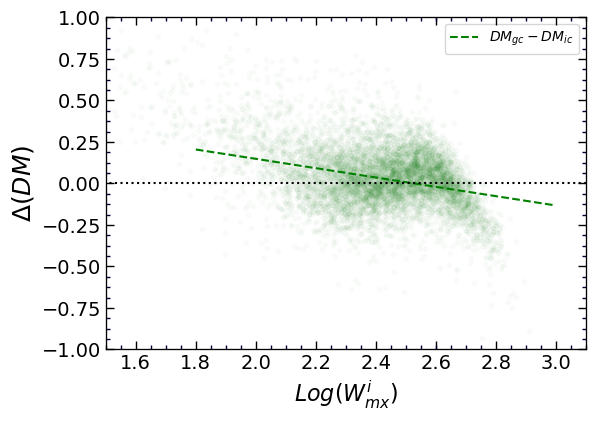

In [536]:
x = np.linspace(1.8,3, 20)

fig = py.figure(figsize=(6,4), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.95, bottom=0.12, left=0.15, right=0.95)
ax = fig.add_subplot(111) 

indx, = np.where((ggg>0) & (iii>0) & (SSqlt>=3))
dDM = DM_g-DM_i
ax.plot(logWimx[indx], dDM[indx], 'g.', alpha=0.02)
P = np.where(logWimx[indx]>2)
fit, cov = curve_fit(lineF, logWimx[indx][P], dDM[indx][P])
a=fit[0]; b=fit[1]
ax.plot(x, a*x+b, '--', color='g', label=r'$DM_{gc}-DM_{ic}$')
    

# indx, = np.where((rrr>0) & (iii>0) & (SSqlt>=3))
# dDM = DM_r-DM_i
# ax.plot(logWimx[indx], dDM[indx], 'r.', alpha=0.02)
# P = np.where(logWimx[indx]>2)
# fit, cov = curve_fit(lineF, logWimx[indx][P], dDM[indx][P])
# a=fit[0]; b=fit[1]
# ax.plot(x, a*x+b, '--', color='r', label=r'$DM_{rc}-DM_{ic}$')

# indx, = np.where((zzz>0) & (iii>0) & (SSqlt>=3))
# dDM = DM_z-DM_i
# ax.plot(logWimx[indx], dDM[indx], '.', alpha=0.02, color='maroon')
# P = np.where(logWimx[indx]>2)
# fit, cov = curve_fit(lineF, logWimx[indx][P], dDM[indx][P])
# a=fit[0]; b=fit[1]
# ax.plot(x, a*x+b, '--', color='maroon', label=r'$DM_{zc}-DM_{ic}$')




set_axes(ax, (1.5,3.1), (-1,1), fontsize=14)

ax.set_xlabel(r'$Log( W_{mx}^i)$', fontsize=16) 
ax.set_ylabel(r'$\Delta (DM)$', fontsize=18) 

ax.legend()

ax.plot([-10,10], [0,0], 'k:')

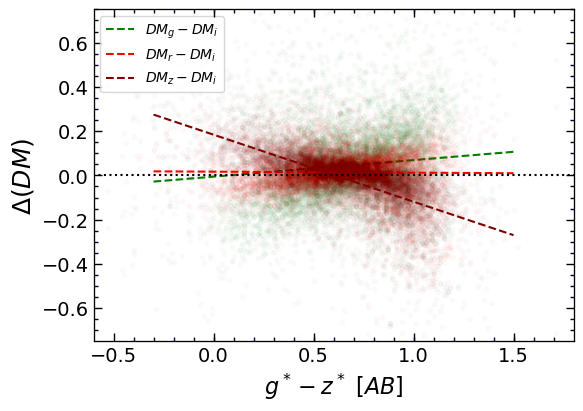

In [537]:
x = np.linspace(-0.3,1.5, 20)

fig = py.figure(figsize=(6,4), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.95, bottom=0.12, left=0.15, right=0.95)
ax = fig.add_subplot(111) 


indx, = np.where((ggg>0) & (iii>0) & (SSqlt>=3))
dDM = DM_g-DM_i
ax.plot(g_z[indx], dDM[indx], 'g.', alpha=0.02)
fit, cov = curve_fit(lineF, g_z[indx], dDM[indx])
a=fit[0]; b=fit[1]
ax.plot(x, a*x+b, '--', color='g', label=r'$DM_{g}-DM_{i}$')

indx, = np.where((rrr>0) & (iii>0) & (SSqlt>=3))
dDM = DM_r-DM_i
ax.plot(g_z[indx], dDM[indx], 'r.', alpha=0.02)
fit, cov = curve_fit(lineF, g_z[indx], dDM[indx])
a=fit[0]; b=fit[1]
ax.plot(x, a*x+b, '--', color='r', label=r'$DM_{r}-DM_{i}$')

indx, = np.where((zzz>0) & (iii>0) & (SSqlt>=3))
dDM = DM_z-DM_i
ax.plot(g_z[indx], dDM[indx], '.', alpha=0.02, color='maroon')
fit, cov = curve_fit(lineF, g_z[indx], dDM[indx])
a=fit[0]; b=fit[1]
ax.plot(x, a*x+b, '--', color='maroon', label=r'$DM_{z}-DM_{i}$')

# indx, = np.where((zzz>0) & (iii>0) & (SSqlt>=3))
# dDM = 0.5*(DM_z+DM_r)-DM_i
# ax.plot(g_z[indx], dDM[indx], '.', alpha=0.02, color='b')


set_axes(ax, (-0.6,1.8), (-0.75,0.75), fontsize=14)

ax.set_xlabel(r'$g^*-z^* \/\/ [AB]$', fontsize=16) 
ax.set_ylabel(r'$\Delta (DM)$', fontsize=18) 
ax.legend()

ax.plot([-10,10], [0,0], 'k:')

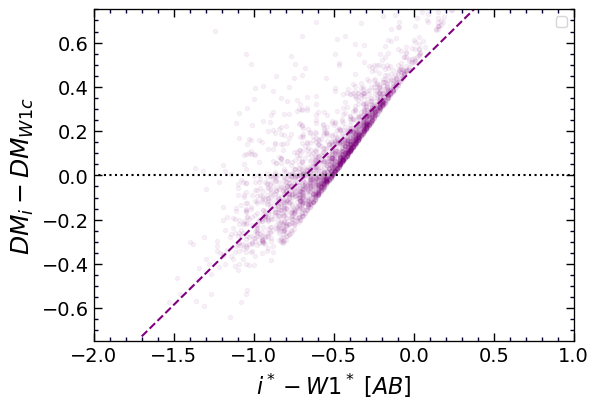

In [538]:
fig = py.figure(figsize=(6,4), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.95, bottom=0.12, left=0.15, right=0.95)
ax = fig.add_subplot(111) 

indx, = np.where((w11>0) & (iii>0)  & (WWqlt>=3)  & (SSqlt>=3))
dDM =  DM_i - DM_1 
ax.plot(i_w1[indx], dDM[indx], '.', alpha=0.05, color='purple')

x = np.linspace(-1.7,0.7, 20)
fit, cov = curve_fit(lineF, i_w1[indx], dDM[indx])
a=fit[0]; b=fit[1]
ax.plot(x, a*x+b, '--', color='purple')

set_axes(ax, (-2,1), (-0.75,0.75), fontsize=14)

ax.set_xlabel(r'$i^*-W1^* \/\/ [AB]$', fontsize=16) 
ax.set_ylabel(r'$DM_{i}-DM_{W1c}$', fontsize=18) 
ax.legend()

ax.plot([-10,10], [0,0], 'k:')

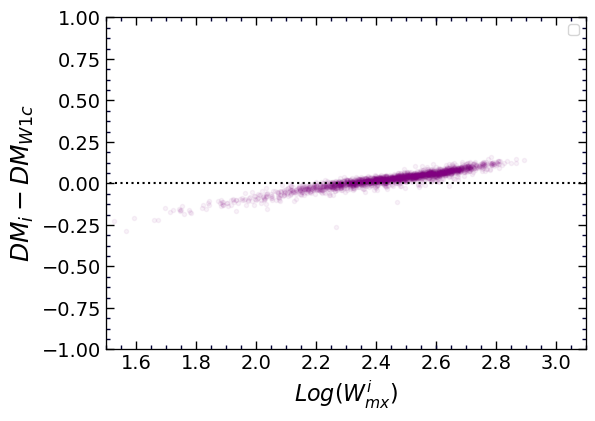

In [544]:
fig = py.figure(figsize=(6,4), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.95, bottom=0.12, left=0.15, right=0.95)
ax = fig.add_subplot(111) 

indx, = np.where((w11>0) & (iii>0) & (zzz>0) & (rrr>0) & (WWqlt>=3)  & (SSqlt>=3))
dDM =  DM_i - DM_1c
ax.plot(logWimx[indx], dDM[indx], '.', alpha=0.05, color='purple')


set_axes(ax, (1.5, 3.1), (-1,1), fontsize=14)


ax.set_xlabel(r'$Log( W_{mx}^i)$', fontsize=16) 
ax.set_ylabel(r'$DM_{i}-DM_{W1c}$', fontsize=18) 

ax.legend()

ax.plot([-10,10], [0,0], 'k:')




In [552]:
indx, = np.where((WWqlt>=2)  & (SSqlt==0))
len(indx)

3206

In [553]:
indx, = np.where((WWqlt>=2)  & (SSqlt>=2))
len(indx)

2217

In [554]:
indx, = np.where((WWqlt==0)  & (SSqlt>=2))
len(indx)

5244